In [1]:
# TODO: 
# move X, E, Z, etc into one vector called state

# Calculate partical filter --- whatever that is
# Estimated partical filter with another NN
# Use estimated partical filter to generate posterior for parameters given data.

# Collect data
# Decide on model
# Estimate parameters and compare to data for various numbers of agents
# ???
# Profit

In [2]:
import sys
sys.path.append('/home/emmet/Documents/code/hetero_simulation/lib')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam, unpack_optimizer_state, pack_optimizer_state
from hetero_simulation.archive.agent import log_utility
from hetero_simulation.ml.utils import *

In [3]:
from jax.config import config
config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)

In [4]:
# Parameters of wealth distribution
A = 0.5
B = 0.2

# Preference and production parameters
alpha = 0.36 # (0, 1)
beta = 0.96 # (0, 1)
delta = 0.025 # (0, 1)
rho_z = 0.95 # (0, 1)
rho_e = 0.9 # (0, 1)
sigma_z = 0.01 # (0, inf)
sigma_e = 0.2 * jnp.sqrt(1 - rho_e**2) # (0, inf)

STRUCT_PARAM = {
    'alpha': alpha, 'beta': beta, 'delta': delta, 'a': A, 'b': B,
    'sigma_z': sigma_z, 'sigma_e': sigma_e, 'rho_z': rho_z, 'rho_e': rho_e
}

STRUCT_PARAM_IDXS = {k: v for k, v in zip(STRUCT_PARAM.keys(), np.arange(len(STRUCT_PARAM.keys())))}
STRUCT_PARAM_ARR = jnp.asarray(np.fromiter(STRUCT_PARAM.values(), dtype=jnp.float32))

AGG_IDXS = {'Xs': jnp.array(list(range(5))), 'Es': jnp.array(list(range(5, 10))), 'Zs': jnp.array(list(range(10, 11)))}
IDO_IDXS = {'xs': jnp.array(list(range(1))), 'es': jnp.array(list(range(1, 2)))}

# Hyper-parameters
N = 2 ** 4
MB = 2 ** 2
N_EPOCH = 250
N_ITER = 10 * (N // MB)
N_FORWARD = 50
T = 200

K = 5 # number of agents (~ size of state space)
M = 4
nn_shapes = jnp.array([M, M, M, M])

In [5]:
@jax.jit
def neural_network(model_params, struct_params, agg_state, ido_state):
    X_tilde = jnp.concatenate([struct_params.reshape(1, -1),
                               agg_state.reshape(1, -1),
                               ido_state.reshape(1, -1)], 
                              axis=1)
    X_tilde = X_tilde @ model_params['theta']
    # l1 = tanh(X_tilde, model_params['w0'], model_params['b0'])
    l2 = tanh(X_tilde, model_params['w1'], model_params['b1'])
    l3 = tanh(l2, model_params['w2'], model_params['b2'])
    # l4 = tanh(jnp.concatenate((l3, e[..., jnp.newaxis], x[..., jnp.newaxis])), model_params['w3'], model_params['b3'])
    return jnp.array([jnp.squeeze(sigmoid(l3, model_params['cwf'], model_params['cbf'])),
                      jnp.squeeze(exp(l3, model_params['lwf'], model_params['lbf']))])


@jax.jit
def fischer_burmeister(a, b):
    return a + b - jnp.sqrt(jnp.power(a, 2) + jnp.power(b, 2))


@jax.jit
def next_X(model_params, struct_params, agg_state):
    R, W = prices(struct_params, agg_state)
    w = jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(agg_state[AGG_IDXS['Xs']], agg_state[AGG_IDXS['Es']]))
    ido_state = jnp.concatenate((agg_state[AGG_IDXS['Es']], jnp.squeeze(w))).reshape(K, 2, -1)
    out = jax.vmap(neural_network, in_axes=(None, None, None, 0))(model_params, struct_params, agg_state, ido_state)
    c = jnp.squeeze(w * out[..., 0])
        
    return (1 - out[..., 0]) * w


@jax.jit
def prices(struct_params, agg_state):
    sumk = jnp.sum(agg_state[AGG_IDXS['Xs']])
    sumexpl = jnp.sum(jnp.exp(agg_state[AGG_IDXS['Es']]))
    w = (1 - struct_params[STRUCT_PARAM_IDXS['alpha']]) * jnp.exp(agg_state[AGG_IDXS['Zs']]) * jnp.power(sumk, struct_params[STRUCT_PARAM_IDXS['alpha']]) * jnp.power(sumexpl, -1 * struct_params[STRUCT_PARAM_IDXS['alpha']])
    r = 1 - struct_params[STRUCT_PARAM_IDXS['delta']] + struct_params[STRUCT_PARAM_IDXS['alpha']] * jnp.exp(agg_state[AGG_IDXS['Zs']]) * jnp.power(sumk, struct_params[STRUCT_PARAM_IDXS['alpha']] - 1) * jnp.power(sumexpl, 1 - struct_params[STRUCT_PARAM_IDXS['alpha']])
    return r, w


@jax.jit
def loss(model_params, struct_params, agg_state, key):
    X = agg_state[AGG_IDXS['Xs']]
    E = agg_state[AGG_IDXS['Es']]
    Z = agg_state[AGG_IDXS['Zs']]
    
    agg_state_1 = next_state(model_params, struct_params, agg_state, key)
    R, W = prices(struct_params, agg_state)
    w = jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(X, E))
    ido_states = jnp.concatenate((agg_state[AGG_IDXS['Es']], w)).reshape(5, 2, -1)
    outputs = jax.vmap(neural_network, in_axes=(None, None, None, 0))(model_params, struct_params, agg_state, ido_states)
    c_rel = outputs[..., 0]
    lm = outputs[..., 1]
    c = w * c_rel
    
    X1 = w - c
    E1 = agg_state_1[AGG_IDXS['Es']]
    R1, W1 = prices(struct_params, agg_state_1)
    
    w1 = jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(X1, E1))
    ido_states_1 = jnp.concatenate((agg_state_1[AGG_IDXS['Es']], w1)).reshape(5, 2, -1)
    c1 = w1 * jax.vmap(neural_network, in_axes=(None, None, None, 0))(model_params, struct_params, agg_state_1, ido_states_1)[..., 0]

    u = lambda c: log_utility()(c)
    g = jax.vmap(lambda c: struct_params[STRUCT_PARAM_IDXS['beta']] * R1 * jax.grad(u)(c))(c1)
    up = jax.vmap(jax.grad(u))(c)
    g_diff = jax.vmap(lambda g, up, lm: (g / up) - lm)(g.reshape(-1, 1), up.reshape(-1, 1), lm.reshape(-1, 1))
    lm_diff = jax.vmap(lambda c, lm: fischer_burmeister(1 - c, 1 - lm))(c_rel.reshape(-1, 1), lm.reshape(-1, 1))

    return g_diff, lm_diff, c_rel


@jax.jit
def batch_loss(model_params, struct_params, agg_states, keys):
    g_diff_1, lm_diff_1, c_rels = jax.vmap(loss, in_axes=(None, 0, 0, None))(model_params, struct_params, agg_states, keys[0])
    g_diff_2, lm_diff_2, c_rels = jax.vmap(loss, in_axes=(None, 0, 0, None))(model_params, struct_params, agg_states, keys[1])
    g2 = g_diff_1 * g_diff_2
    lm2 = lm_diff_1 * lm_diff_2

    return jnp.squeeze(jnp.mean(g2 + lm2)**2), (jnp.squeeze(jnp.mean(g2)), jnp.squeeze(jnp.mean(lm2)), c_rels)


@jax.jit
def next_state(model_params, struct_params, agg_state, key):   
    X_prime = next_X(model_params, struct_params, agg_state)
    E_prime = struct_params[STRUCT_PARAM_IDXS['rho_e']] * agg_state[AGG_IDXS['Es']] +\
              struct_params[STRUCT_PARAM_IDXS['sigma_e']] * jax.random.normal(key, shape=(K,))
    Z_prime = struct_params[STRUCT_PARAM_IDXS['rho_z']] * agg_state[AGG_IDXS['Zs']] +\
              struct_params[STRUCT_PARAM_IDXS['sigma_z']] * jax.random.normal(key)  
    
    agg_states = jnp.concatenate((X_prime, E_prime, Z_prime))
    return agg_states


@jax.tree_util.Partial(jax.jit, static_argnums=(4,))
def simulate_state_forward(model_params, struct_params, agg_states, key, n_forward=N_FORWARD):
    if len(agg_states.shape) == 1:
        agg_states = agg_states.reshape(1, -1)
    if len(struct_params.shape) == 1:
        struct_params = struct_params.reshape(1, -1)
    assert agg_states.shape[0] == struct_params.shape[0]

    keys = jax.random.split(key, n_forward * agg_states.shape[0]).reshape(n_forward, agg_states.shape[0], 2)
    
    @jax.jit
    def inner_loop(agg_states, i):
        return jax.vmap(next_state, in_axes=(None, 0, 0, 0))(model_params, struct_params, agg_states, keys[i]), None
    
    agg_states, _ = jax.lax.scan(inner_loop, agg_states, jnp.arange(n_forward))
    
    return jnp.squeeze(agg_states), keys[-1, -1]


@jax.jit
def generate_struct_params(key):
    keys = jax.random.split(key, 3)
    
    alpha = jax.random.uniform(keys[0], minval=0.2, maxval=0.5) * jnp.ones(1)
    beta = jax.random.uniform(keys[1], minval=0.8, maxval=1.) * jnp.ones(1)
    delta = jax.random.uniform(keys[2], minval=0.001, maxval=0.1) * jnp.ones(1)
    a = STRUCT_PARAM['a'] * jnp.ones(1)
    b = STRUCT_PARAM['b'] * jnp.ones(1)
    rho_z = STRUCT_PARAM['rho_z'] * jnp.ones(1)
    rho_e = STRUCT_PARAM['rho_e'] * jnp.ones(1)
    sigma_z = STRUCT_PARAM['sigma_z'] * jnp.ones(1)
    sigma_e = STRUCT_PARAM['sigma_e'] * jnp.ones(1)
    
    struct_params = jnp.concatenate((alpha, beta, delta, a, b, rho_z, rho_e, sigma_z, sigma_e))
        
    return struct_params


@jax.tree_util.Partial(jax.jit, static_argnums=(2, 3))
def generate_random_state(model_params, key, n_forward=N_FORWARD, batch_size=N//2, struct_params=None): 
    if struct_params is None:
        keys = jax.random.split(key, batch_size)
        struct_params = jax.vmap(generate_struct_params)(keys)
    elif len(struct_params.shape) == 1:
        struct_params = struct_params.reshape(1, -1)

    samples = struct_params.shape[0]
    Zs = jnp.ones(shape=(samples, 1))
    Es = jnp.ones(shape=(samples, K))
    Xs = jnp.exp(STRUCT_PARAM['a'] * jax.random.normal(
        jax.random.PRNGKey(np.random.randint(1, int(1e8))), 
        shape=(samples, K))) + STRUCT_PARAM['b']
    
    agg_states = jnp.concatenate((Xs, Es, Zs), axis=1)
 
    assert struct_params.shape[0] == agg_states.shape[0]
    if n_forward > 0:
        agg_states, key = simulate_state_forward(model_params, struct_params, agg_states, key, n_forward=n_forward)
        
    return agg_states, struct_params, key

In [6]:
scale = 0.5
init_keys = jax.random.split(jax.random.PRNGKey(5), 11)
theta0 = jax.random.gamma(init_keys[0], scale, shape=(2 * K + 3 + len(STRUCT_PARAM.values()), nn_shapes[0]))
w00 = scale * jax.random.normal(init_keys[1], shape=(2 * K + 3 + len(STRUCT_PARAM.values()), nn_shapes[0]))
w01 = scale * jax.random.normal(init_keys[2], shape=(nn_shapes[0], nn_shapes[1]))
w02 = scale * jax.random.normal(init_keys[3], shape=(nn_shapes[1], nn_shapes[2]))
w03 = scale * jax.random.normal(init_keys[4], shape=(nn_shapes[2] + 2, nn_shapes[3]))
w0f = scale * jax.random.normal(init_keys[5], shape=(nn_shapes[1], 1))
b00 = scale * jax.random.normal(init_keys[6], shape=(1, nn_shapes[0]))
b01 = scale * jax.random.normal(init_keys[7], shape=(1, nn_shapes[1]))
b02 = scale * jax.random.normal(init_keys[8], shape=(1, nn_shapes[2]))
b03 = scale * jax.random.normal(init_keys[9], shape=(1, nn_shapes[3]))
b0f = scale * jax.random.normal(init_keys[10], shape=(1, 1))

params0 = {
    'theta': theta0, 'w0': w00, 'w1': w01, 'w2': w02, 'w3': w03, 'cwf': w0f, 'lwf': w0f, 'b0': b00, 'b1': b01, 'b2': b02, 'b3': b03, 'cbf': b0f, 'lbf': b0f
}

In [7]:
def training_loop(opt_state, tol=1e-10, max_iter=10**4, rand_struct_params=True):
    j = 0
    key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
    val_loss = jnp.inf
    grad = {'0': jnp.inf}
    opt_init, opt_update, get_params = adam(step_size=0.001)
    model_params = get_params(opt_state)

    if rand_struct_params:
        agg_states, struct_params, key = generate_random_state(model_params, key)
    else:
        agg_states, struct_params, key = generate_random_state(model_params, key, struct_params=jnp.repeat(jnp.asarray(list(STRUCT_PARAM.values()))[jnp.newaxis], (N // 2), axis=0))

    while j < max_iter and max([jnp.max(jnp.abs(v)) for k, v in grad.items()]) > tol and jnp.abs(val_loss) > tol:
        jj = 0
        while jj < N_ITER:
            keys = jax.random.split(key, 2)
            key = keys[-1]
            model_params = get_params(opt_state)

            sample = jax.random.choice(jax.random.PRNGKey(np.random.randint(1, int(1e8))), jnp.arange(N // 2), shape=(2, MB // 2,))
            val, grad = jax.value_and_grad(batch_loss, has_aux=True)(model_params, struct_params[sample[0]], agg_states[sample[1]], keys)
            val_loss = jnp.abs(val[0])
            c_star_rel = val[1][-1]
            if not (c_star_rel < 1).all():
                print(jnp.concatenate((c_star_rel, struct_params[sample[0], :3]), axis=1))
                raise ValueError('Invalid consumption choices observed') 
            if jnp.isnan(val_loss):
                raise ValueError('Loss is nan')

            c_val = jnp.abs(val[1][0])
            kt_val = jnp.abs(val[1][1])
            opt_state = opt_update(j * N_ITER + jj, grad, opt_state)

            jj += 1

        # Start from a new random position, before moving into the current implied ergodic set
        model_params = get_params(opt_state)
        if N_FORWARD > 0:
            if rand_struct_params:
                agg_states, struct_params, key = generate_random_state(model_params, key)
            else:
                agg_states, struct_params, key = generate_random_state(model_params, key, struct_params=jnp.repeat(jnp.asarray(list(STRUCT_PARAM.values()))[jnp.newaxis], (N // 2), axis=0))

        if j % 1 == 0:
            trained_params = unpack_optimizer_state(opt_state)
            # pickle.dump(trained_params, open(f'./ks_cont_models/ks_cont_model_{K}_{j}.pkl', 'wb'))
            print(f'Iteration: {j}  Total Loss: {val_loss:.2e}  C Loss: {c_val:.2e}  KT Loss: {kt_val:.2e}' +\
                  f'  Max Grad: {max([jnp.max(jnp.abs(v)) for k, v in grad.items()]):.2e}' +\
                  f'  Max Param: {max([jnp.max(jnp.abs(v)) for k, v in model_params.items()]):.2e}')
        j += 1
        
    return opt_state

In [8]:
# Load pre-fit model
opt_init, opt_update, get_params = adam(step_size=0.001)
saved_params = pickle.load(open(f'./ks_cont_models/ks_cont_model_{K}_central.pkl', 'rb'))
central_opt_state = pack_optimizer_state(saved_params)
central_params = get_params(central_opt_state)

In [9]:
# opt_init, opt_update, get_params = adam(step_size=0.001)
# opt_state = opt_init(params0)

# central_opt_state = training_loop(opt_state, max_iter=N_EPOCH, rand_struct_params=False)
# central_params = get_params(central_opt_state)
# pickle.dump(unpack_optimizer_state(central_opt_state), open(f'./ks_cont_models/ks_cont_model_{K}_central.pkl', 'wb'))

In [10]:
# Load pre-fit model
range_opt_init, opt_update, get_params = adam(step_size=0.001)
range_saved_params = pickle.load(open(f'./ks_cont_models/ks_cont_model_{K}_range.pkl', 'rb'))
range_opt_state = pack_optimizer_state(range_saved_params)
range_params = get_params(range_opt_state)

In [11]:
# range_opt_state = training_loop(opt_state, max_iter=N_EPOCH, rand_struct_params=True)
# range_params = get_params(range_opt_state)
# pickle.dump(unpack_optimizer_state(range_opt_state), open(f'./ks_cont_models/ks_cont_model_{K}_range.pkl', 'wb'))

### Experimental: SMM

In [12]:
# key = jax.random.PRNGKey(123)
# # Note we draw from the ergodic distribution, but which parameters should we use to do this?
# train_agg_states, train_struct_params, key = generate_random_state(params0, key, struct_params=None)
# true_struct_params = jnp.repeat(jnp.asarray(list(STRUCT_PARAM.values()))[jnp.newaxis], N // 2, axis=0)
# Rs, Ws = jax.vmap(prices)(train_struct_params, train_agg_states)
# ws = jax.vmap(lambda agg_state, R, W: jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(agg_state[AGG_IDXS['Xs']], agg_state[AGG_IDXS['Es']])))(train_agg_states, Rs, Ws)
# ido_states = jnp.squeeze(jax.vmap(lambda w, agg_state: jnp.concatenate((agg_state[AGG_IDXS['Es']], jnp.squeeze(w))).reshape(5, 2, -1))(ws, train_agg_states))

In [13]:
# true_preds = jax.vmap(jax.vmap(neural_network, in_axes=(None, None, None, 0)), in_axes=(None, 0, 0, 0))(central_params, true_struct_params, train_agg_states, ido_states)

In [14]:
# range_preds = jax.vmap(jax.vmap(jax.vmap(neural_network, in_axes=(None, None, None, 0)), in_axes=(None, None, 0, 0)), in_axes=(None, 0, None, None))(range_params, train_struct_params, train_agg_states, ido_states)

In [15]:
# diffs = jnp.mean(jax.vmap(
#                     jax.vmap(
#                         jax.vmap(lambda true_pred, range_pred: true_pred - range_pred, 
#                                  in_axes=(0, 0)), 
#                         in_axes=(0, 0)), 
#                     in_axes=(None, 0))(true_preds, range_preds), axis=(1, 2))
# log_liks = jax.scipy.stats.multivariate_normal.logpdf(diffs, mean=jnp.ones(2), cov=jnp.diag(jnp.ones(2) / MB))
# log_liks

In [16]:
# @jax.jit
# def diff_fn(train_struct_params):
#     true_preds = jax.vmap(jax.vmap(neural_network, in_axes=(None, None, None, 0)), in_axes=(None, 0, 0, 0))(central_params, true_struct_params, train_agg_states, ido_states)
#     range_preds = jax.vmap(jax.vmap(jax.vmap(neural_network, in_axes=(None, None, None, 0)), in_axes=(None, None, 0, 0)), in_axes=(None, 0, None, None))(range_params, train_struct_params, train_agg_states, ido_states)
#     diffs = jnp.mean(jax.vmap(
#                     jax.vmap(
#                         jax.vmap(lambda true_pred, range_pred: true_pred - range_pred, 
#                                  in_axes=(0, 0)), 
#                         in_axes=(0, 0)), 
#                     in_axes=(None, 0))(true_preds, range_preds), axis=(1, 2))
#     return diffs[:, 0]

# grads = jax.jacfwd(diff_fn)(train_struct_params)

### Particle Filter

In [17]:
key = jax.random.PRNGKey(123)
# Note we draw from the ergodic distribution, but which parameters should we use to do this?
train_agg_states, train_struct_params, key = generate_random_state(params0, key, struct_params=None)
true_struct_params = jnp.repeat(jnp.asarray(list(STRUCT_PARAM.values()))[jnp.newaxis], N // 2, axis=0)

In [52]:
true_struct_params[0]

DeviceArray([0.36      , 0.96      , 0.025     , 0.5       , 0.2       ,
             0.01      , 0.08717798, 0.95      , 0.9       ],            dtype=float64)

In [53]:
STRUCT_PARAM

{'alpha': 0.36,
 'beta': 0.96,
 'delta': 0.025,
 'a': 0.5,
 'b': 0.2,
 'sigma_z': 0.01,
 'sigma_e': DeviceArray(0.08717798, dtype=float64, weak_type=True),
 'rho_z': 0.95,
 'rho_e': 0.9}

In [61]:
# Simulate data from the "true" model to use as data for the particle filter
t_burn = 200
key = jax.random.PRNGKey(235)
struct_params = true_struct_params[0]
init_state, _, key = generate_random_state(central_params, key, n_forward=500, struct_params=struct_params)


def next_states(carry, xs=None):
    states, key = carry
    next_state, new_key = simulate_state_forward(central_params, struct_params, states, key, n_forward=1)
    R, W = prices(true_struct_params[0], states)
    w = jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(states[AGG_IDXS['Xs']], states[AGG_IDXS['Es']]))    
    ido_states = jnp.squeeze(jnp.concatenate((states[AGG_IDXS['Es']], w)).reshape(K, 2))
    preds = jax.vmap(neural_network, in_axes=(None, None, None, 0))(central_params, struct_params, states, ido_states)
    return (next_state, new_key), w * preds[..., 0]
    
init_carry = (init_state, key)
_, cs = jax.lax.scan(next_states, init_carry, xs=None, length=T+t_burn)
cs = cs[t_burn:]
cs[:5]

DeviceArray([[2.33356122, 1.72686798, 2.04898146, 2.12889787, 2.00632565],
             [2.29498955, 1.76358494, 2.12650499, 2.14621786, 1.99111546],
             [2.299148  , 1.79381567, 2.20908629, 2.15982813, 1.97093196],
             [2.26763697, 1.84500548, 2.27020786, 2.16431096, 1.94505641],
             [2.25419106, 1.8754396 , 2.3148487 , 2.1615693 , 1.95199953]],            dtype=float64)

<AxesSubplot:>

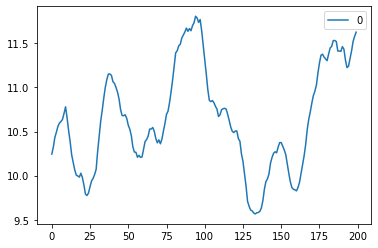

In [62]:
pd.DataFrame(jnp.sum(cs, axis=1)).plot()

In [72]:
# HS
# @jax.jit
# def multinomial(states, weights, key):
#     return states[jax.random.categorical(key, jnp.log(weights), shape=(weights.shape[0],))]


# FVRR
@jax.jit
def multinomial(states, weights, key):
    idxs = jax.random.categorical(key, weights, shape=(weights.shape[0],))
    return states[idxs], weights[idxs]


@jax.jit
def get_inc_weights(pred_ys, real_y, std=1.):
    return jax.vmap(lambda pred_y: 
                    jax.scipy.stats.multivariate_normal.pdf(pred_y - real_y, 
                                                            mean=jnp.zeros(real_y.shape[0]),
                                                            cov=std*jnp.diag(jnp.ones(real_y.shape[0]))))(pred_ys)


@jax.jit
def get_observables(model_params, struct_params, states):
    # TODO: Confirm shapes are correct, should vmap states over 1...M
    Rs, Ws = jax.vmap(prices, in_axes=(None, 0))(struct_params, states)
    ws = jax.vmap(lambda state, R, W: jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(state[AGG_IDXS['Xs']], state[AGG_IDXS['Es']])))(states, Rs, Ws)    
    ido_states = jnp.squeeze(jax.vmap(lambda w, state: jnp.concatenate((state[AGG_IDXS['Es']], jnp.squeeze(w))).reshape(K, 2, -1))(ws, states))
    range_preds = jax.vmap(jax.vmap(neural_network, in_axes=(None, None, None, 0)), in_axes=(None, None, 0, 0))(model_params, struct_params, states, ido_states)
    observables = ws * range_preds[..., 0] # Assume only consumption is visible, for now
    return observables


# Herbst and Schorfheide
# @jax.jit
# def particle_loop(model_params, struct_params, data, std, carry, t):
#     states, weights, key = carry
#     keys = jax.random.split(key, states.shape[0])
    
#     new_states, new_keys = jax.vmap(simulate_state_forward, in_axes=(None, None, 0, 0, None))(model_params, struct_params, states, keys, 1)
#     pred_ys = get_observables(model_params, struct_params, new_states)
#     inc_weights = get_inc_weights(pred_ys, data[t], std=std)
    
#     sum_weights = jnp.mean(inc_weights * weights)
#     norm_weights = (inc_weights * weights) / sum_weights
    
#     ess = (weights.shape[0]) / jnp.sum(inc_weights**2)
#     rho = jnp.int32(ess < (weights.shape[0]) / 2)
    
#     out_states = rho * multinomial(new_states, norm_weights, key) + (1 - rho) * new_states
#     out_weights = rho * jnp.ones(weights.shape[0]) + (1 - rho) * norm_weights
    
#     carry = (out_states, out_weights, new_keys[-1])
#     return carry, (out_states, weights, inc_weights)


# Fernandez-Villaverde and Rubio-Ramirez
@jax.jit
def particle_loop(model_params, struct_params, data, std, carry, t):
    states, weights, key = carry
    keys = jax.random.split(key, states.shape[0])
    
    new_states, new_keys = jax.vmap(simulate_state_forward, in_axes=(None, None, 0, 0, None))(model_params, struct_params, states, keys, 1)
    pred_ys = get_observables(model_params, struct_params, new_states)
    inc_weights = get_inc_weights(pred_ys, data[t], std=std)
    
    sum_weights = jnp.mean(inc_weights)
    norm_weights = (inc_weights) / sum_weights
    
    out_states, out_weights = multinomial(new_states, norm_weights, key)
    
    carry = (out_states, out_weights, new_keys[-1])
    return carry, inc_weights


@jax.tree_util.Partial(jax.jit, static_argnums=(5, 6))
def particle_filter(model_params, struct_params, data, key, std=1., batch_size=2**9, t_burn=50):
    '''
    model_params: 1 example of model params, fit over a range of structural parameters
    struct_params: 1 example of structural params
    data: a DeviceArray([T,]) of data to match observables from model 
    key: a jax.random.PRNGKey
    '''
    init_states, _, key = generate_random_state(model_params, key, struct_params=jnp.repeat(struct_params.reshape(1, -1), batch_size, axis=0), n_forward=0)
    init_weights = jnp.ones(batch_size)
    # states and weights are a batch of M = N // 2 we will average over but there is only one example of "struct_params"
    inner_loop = jax.tree_util.Partial(particle_loop, model_params, struct_params, data, std)
    # Herbst and Schorfheide
    # _, (states, weights, inc_weights) = jax.lax.scan(inner_loop, (init_states, init_weights, key), jnp.arange(T))
    # ll = jnp.sum(jnp.log(jnp.mean(inc_weights * weights, axis=1)))
    
    # Fernandez-Villaverde and Rubio-Ramirez
    _, inc_weights = jax.lax.scan(inner_loop, (init_states, init_weights, key), jnp.arange(T))
    ll = jnp.mean(jnp.log(jnp.mean(inc_weights[t_burn:], axis=1)))
    return ll

In [73]:
# LL of true parameters, using true model
true_ll = particle_filter(central_params, true_struct_params[0], cs, key, std=1.)
true_ll

DeviceArray(-4.86352015, dtype=float64)

In [30]:
# LL of some random parameters, using model fit over range of parameters
key  = jax.random.PRNGKey(1)
agg_states, struct_params, key = generate_random_state(range_params, key, n_forward=0, batch_size=32, struct_params=None)
keys = jax.random.split(key, struct_params.shape[0])
lls = jax.vmap(particle_filter, in_axes=(None, 0, None, 0, None))(range_params, struct_params, cs, keys, 1.)
lls

DeviceArray([-5.29725333, -5.37620012, -5.3432726 , -5.33386716,
             -5.31751722, -5.45214993, -5.36820649, -5.32992951,
             -5.38698602, -5.34046039, -5.29955243, -5.25916698,
             -5.37968627, -5.41937003, -5.41583416, -5.41783327,
             -5.3003913 , -5.26099896, -5.26623531, -5.42280344,
             -5.30519301, -5.31793879, -5.39046621, -5.30008633,
             -5.43747972, -5.36962521, -5.27311578, -5.27750904,
             -5.30052595, -5.33075774, -5.27368304, -5.40655427],            dtype=float64)

### Particle Filter Neural Network

In [76]:
# Generate a fixed dataset against which to fit the particle filter nn
data_size = 100
batch_size = 10
key = jax.random.PRNGKey(825)
agg_states, struct_params, key = generate_random_state(range_params, key, n_forward=0, batch_size=data_size, struct_params=None)
keys = jax.random.split(key, struct_params.shape[0])

# Hold all but one of the params fixed at their true value
# struct_params = struct_params.at[:, 0].set(STRUCT_PARAM['alpha'])
struct_params = struct_params.at[:, 1].set(STRUCT_PARAM['beta'])
struct_params = struct_params.at[:, 2].set(STRUCT_PARAM['delta'])


lls = jnp.array([])
samples = 0
# Split this task into pieces, as the vmap takes too much memory to do in one chunk
while samples < data_size:
    ll = jax.vmap(particle_filter, in_axes=(None, 0, None, 0))(range_params, struct_params[samples:samples+batch_size], cs, keys[samples:samples+batch_size])
    lls = jnp.concatenate((lls, ll))
    samples += batch_size
    print(f'Samples generated: {samples}')

assert not jnp.isnan(lls).any()


Samples generated: 10
Samples generated: 20
Samples generated: 30
Samples generated: 40
Samples generated: 50
Samples generated: 60
Samples generated: 70
Samples generated: 80
Samples generated: 90
Samples generated: 100


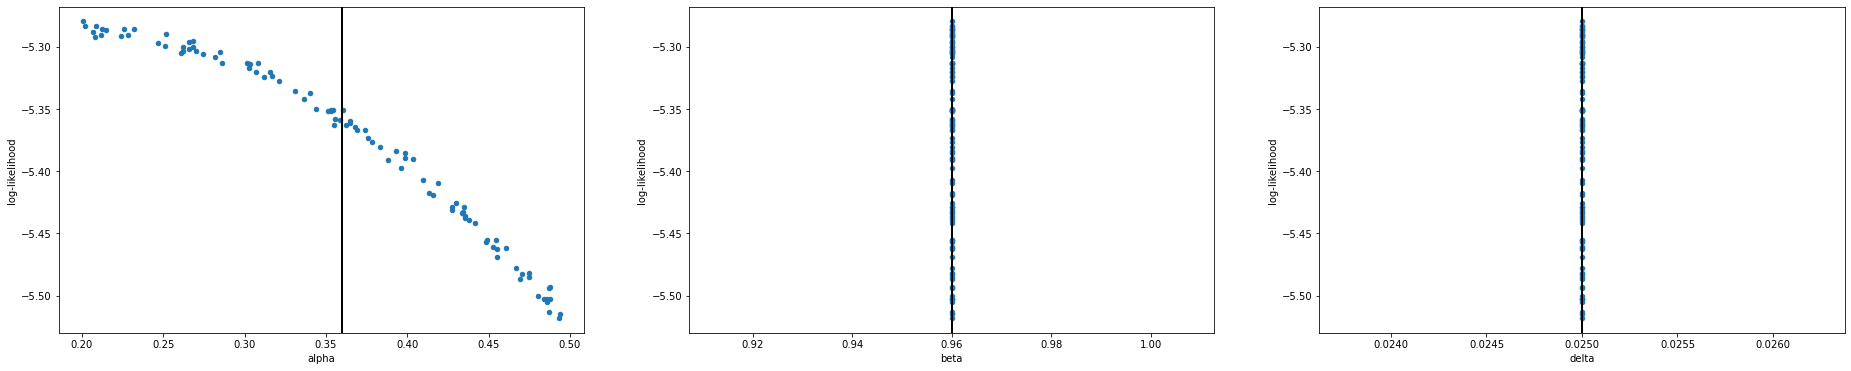

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(32, 6))
df = pd.DataFrame(jnp.concatenate((struct_params[:, :3], lls.reshape(-1, 1)), axis=1), columns=['alpha', 'beta', 'delta', 'log-likelihood'])
df.plot(kind='scatter', x='alpha', y='log-likelihood', ax=axes[0])
df.plot(kind='scatter', x='beta', y='log-likelihood', ax=axes[1])
df.plot(kind='scatter', x='delta', y='log-likelihood', ax=axes[2])

axes[0].axvline(x=STRUCT_PARAM['alpha'], linewidth=2, color='k')
axes[1].axvline(x=STRUCT_PARAM['beta'],  linewidth=2, color='k')
axes[2].axvline(x=STRUCT_PARAM['delta'], linewidth=2, color='k')

In [21]:
scale = 0.5
init_keys = jax.random.split(jax.random.PRNGKey(65), 8)

w00 = scale * jax.random.normal(init_keys[0], shape=(true_struct_params[0].shape[0], nn_shapes[0]))
w01 = scale * jax.random.normal(init_keys[1], shape=(nn_shapes[0], nn_shapes[1]))
w02 = scale * jax.random.normal(init_keys[2], shape=(nn_shapes[1], nn_shapes[2]))
w0f = scale * jax.random.normal(init_keys[3], shape=(nn_shapes[1], 1))
b00 = scale * jax.random.normal(init_keys[4], shape=(1, nn_shapes[0]))
b01 = scale * jax.random.normal(init_keys[5], shape=(1, nn_shapes[1]))
b02 = scale * jax.random.normal(init_keys[6], shape=(1, nn_shapes[2]))
b0f = scale * jax.random.normal(init_keys[7], shape=(1, 1))

pf_params0 = {
    'w0': w00, 'w1': w01, 'w2': w02, 'wf': w0f, 'b0': b00, 'b1': b01, 'b2': b02, 'bf': b0f
}

In [22]:
@jax.jit
def particle_neural_network(params, struct_params):
    l1 = tanh(struct_params, params['w0'], params['b0'])
    l2 = tanh(l1, params['w1'], params['b1'])
    l3 = tanh(l2, params['w2'], params['b2'])
    return linear(l3, params['wf'], params['bf'])


@jax.tree_util.Partial(jax.jit, static_argnums=(5,))
def pf_loss(params, model_params, struct_params, data, key, particles):
    pf_ll = particle_filter(model_params, struct_params, data, key, batch_size=particles)
    nn_ll = particle_neural_network(params, struct_params)

    return (nn_ll - pf_ll) ** 2


@jax.tree_util.Partial(jax.jit, static_argnums=(5,))
def pf_batch_loss(params, model_params, struct_params, data, keys, particles=128):
    losses = jax.vmap(pf_loss, in_axes=(None, None, 0, None, 0, None))(params, model_params, struct_params, data, keys, particles)
    losses = jnp.nan_to_num(losses, jnp.mean(losses))
    return jnp.mean(losses)

In [41]:
key = jax.random.PRNGKey(1)
agg_states, struct_params, key = generate_random_state(range_params, key, n_forward=0, batch_size=32, struct_params=None)
pf_batch_loss(pf_params0, range_params, struct_params, cs, jax.random.split(jax.random.PRNGKey(1), struct_params.shape[0]))

DeviceArray(11034102.19640663, dtype=float64)

In [57]:
# Simultaniously fit the policy nn and the particle filter nn, given some observed data
def pf_training_loop(pf_params, pl_params, data, tol=1e-6, max_iter=10**6, batch_size=128, particles=128):
    key = jax.random.PRNGKey(1)
    pf_opt_init, pf_opt_update, pf_get_params = adam(step_size=1.)
    pl_opt_init, pl_opt_update, pl_get_params = adam(step_size=0.01)
    
    pf_opt_state = pf_opt_init(pf_params)
    pl_opt_state = pl_opt_init(pl_params)
    
    agg_states, struct_params, key = generate_random_state(pl_params, key, n_forward=0, batch_size=batch_size, struct_params=None)

    pf_loss = jnp.inf
    pl_loss = jnp.inf
    loss = jnp.inf

    i = 0

    while loss > tol and i < max_iter:
        keys = jax.random.split(key, 2 * batch_size + 1)

        # Update the policy nn parameters
        pl_params = pl_get_params(pl_opt_state)
        val, pl_grad = jax.value_and_grad(batch_loss, has_aux=True)(pl_params, struct_params, agg_states, keys[:batch_size])
        pl_loss = val[0]
        c_star_rel = val[1][-1]
        if not (c_star_rel < 1).all():
            print(jnp.concatenate((c_star_rel, struct_params[sample[0], :3]), axis=1))
            print('Invalid consumption choices observed') 
            break
        if jnp.isnan(pl_loss):
            print('Loss is nan')
            break
        pl_opt_state = pl_opt_update(i, pl_grad, pl_opt_state)

        # Update the particle filter nn parameters
        if i > 100:
            pl_params = pl_get_params(pl_opt_state)
            pf_params = pf_get_params(pf_opt_state)
            pf_loss, pf_grad = jax.value_and_grad(pf_batch_loss)(pf_params, pl_params, struct_params, data, keys[batch_size:2*batch_size], particles=particles)
            
            if jnp.isnan(pf_loss) or any([jnp.isnan(x).any() for x in pf_grad.values()]):
                print('Particle Filter Loss was nan')
                break
            pf_opt_state = pf_opt_update(i, pf_grad, pf_opt_state)
        
        key = keys[-1]
        i += 1
        loss = pf_loss + pl_loss
        # Simulate states forward, and generate new batch of struct_params
        if i % 10 == 0:
            agg_states, struct_params, key = generate_random_state(pl_params, key, n_forward=N_FORWARD, batch_size=batch_size, struct_params=None)

        if i % 100 == 0 or i > 100:
            print(f'Iteration: {i}\tPolicy Loss: {pl_loss:.2e}\tParticle Filter Loss: {pf_loss:.2e}')
    
    return get_params(pf_opt_state), get_params(pl_opt_state)
    

pf_params, pl_params = pf_training_loop(pf_params0, range_params, cs)

Iteration: 100	Policy Loss: 3.41e-04	Particle Filter Loss: inf
Iteration: 101	Policy Loss: 1.00e-04	Particle Filter Loss: inf
Iteration: 102	Policy Loss: 6.13e-04	Particle Filter Loss: 1.08e+07
Iteration: 103	Policy Loss: 4.62e-04	Particle Filter Loss: 1.08e+07
Iteration: 104	Policy Loss: 2.36e-04	Particle Filter Loss: 1.08e+07
Iteration: 105	Policy Loss: 2.00e-04	Particle Filter Loss: 1.08e+07
Iteration: 106	Policy Loss: 3.18e-04	Particle Filter Loss: 1.07e+07
Iteration: 107	Policy Loss: 3.72e-04	Particle Filter Loss: 1.07e+07
Iteration: 108	Policy Loss: 1.70e-04	Particle Filter Loss: 1.06e+07
Iteration: 109	Policy Loss: 2.08e-04	Particle Filter Loss: 1.06e+07
Iteration: 110	Policy Loss: 4.17e-04	Particle Filter Loss: 1.05e+07
Iteration: 111	Policy Loss: 2.68e-04	Particle Filter Loss: 1.05e+07
Iteration: 112	Policy Loss: 6.08e-04	Particle Filter Loss: 1.04e+07


KeyboardInterrupt: 

In [45]:
# Fit the particle filter neural network to a predefined set of ll observations
@jax.jit
def temp_batch_loss(params, struct_params, lls):
    preds = jax.vmap(particle_neural_network, in_axes=(None, 0))(params, struct_params)
    return jnp.mean((preds - lls)**2)


def pf_training_loop(pf_params, struct_params, lls, tol=1e-6, max_iter=1000, batch_size=128, particles=128):
    key = jax.random.PRNGKey(1)
    pf_opt_init, pf_opt_update, pf_get_params = adam(step_size=0.01)
    pf_opt_state = pf_opt_init(pf_params)

    pf_loss = jnp.inf
    i = 0

    while pf_loss > tol and i < max_iter:
        keys = jax.random.split(key, batch_size)

        sample = jax.random.choice(key, struct_params.shape[0], shape=(batch_size,))
        # pf_params = pf_get_params(pf_opt_state)
        pf_loss, pf_grad = jax.value_and_grad(temp_batch_loss)(pf_params, struct_params, lls)
        
        if jnp.isnan(pf_loss) or any([jnp.isnan(x).any() for x in pf_grad.values()]):
            print('Particle Filter Loss was nan')
            break
        
        pf_params = {k: pf_params[k] - (1/(i+1)) * pf_grad[k] for k in pf_params.keys()}
        # pf_opt_state = pf_opt_update(i, pf_grad, pf_opt_state)
        
        _, key = jax.random.split(key, 2)
        i += 1

        if i % 100 == 0:
            print(f'Iteration: {i}\tParticle Filter Loss: {pf_loss:.2e}')
    
    return pf_params # pf_get_params(pf_opt_state)
    

pf_params = pf_training_loop(pf_params0, struct_params, lls)

Iteration: 100	Particle Filter Loss: 1.00e+04
Iteration: 200	Particle Filter Loss: 1.00e+04
Iteration: 300	Particle Filter Loss: 1.00e+04
Iteration: 400	Particle Filter Loss: 1.00e+04
Iteration: 500	Particle Filter Loss: 1.00e+04
Iteration: 600	Particle Filter Loss: 1.00e+04
Iteration: 700	Particle Filter Loss: 1.00e+04
Iteration: 800	Particle Filter Loss: 1.00e+04
Iteration: 900	Particle Filter Loss: 1.00e+04
Iteration: 1000	Particle Filter Loss: 1.00e+04


## Plotting Stuff

In [ ]:
_, _, get_params = adam(step_size=0.001)
saved_state = pickle.load(open(f'./ks_cont_models/ks_cont_model_{K}_990.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_state)
params = get_params(opt_state)

key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
keys = jax.random.split(key, N // 2)
Xs, Zs, Es, struct_params, key = generate_random_state(params, key)

In [ ]:
key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
idx = jax.random.choice(key, jnp.arange(N), shape=(5,))

X = Xs
Z = Zs
E = Es
e = E[:, 0]

# x_range = jnp.linspace(jnp.min(ws), jnp.max(ws), 100)
x_range = jnp.linspace(0, 10, 100)
c_range = jax.vmap(lambda X, E, Z, e: jax.vmap(lambda x: neural_network(params, STRUCT_PARAM_ARR, X, E, Z, e, x)[0])(x_range))(X, Z, E, e)
data = pd.DataFrame(jnp.concatenate((x_range.reshape(-1, 1), c_range.T), axis=1), dtype=np.float32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
_ = data.plot(x=0, y=jnp.arange(Xs.shape[0]) + 1, ax=ax, legend=False)
_ = fig.suptitle(f'Optimal consumption (as a function of idiosyncratic state) across some aggregate states drawn from the ergodic distribution', fontsize=16)

In [ ]:
key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
idx = jax.random.choice(key, jnp.arange(N), shape=(5,))

X = Xs[0]
Z = Zs[0]
E = Es[0]
e = E[0]

# x_range = jnp.linspace(jnp.min(ws), jnp.max(ws), 100)
x_range = jnp.linspace(0, 10, 100)
c_range = jax.vmap(lambda config: jax.vmap(lambda x: neural_network(params, config, X, E, Z, e, x)[0])(x_range))(struct_params)

data = pd.DataFrame(jnp.concatenate((x_range.reshape(-1, 1), c_range.T), axis=1), dtype=np.float32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
_ = data.plot(x=0, y=jnp.arange(struct_params.shape[0]) + 1, ax=ax, legend=False)
_ = fig.suptitle(f'Optimal consumption (as a function of idiosyncratic state) across some structural parameters drawn', fontsize=16)

In [ ]:
# @jax.tree_util.Partial(jax.jit, static_argnums=(0,))
def generate_struct_param_range(size=1000):
    abd = jnp.array(jnp.meshgrid(jnp.linspace(0, 1, size), jnp.linspace(0, 1, size), jnp.linspace(0, 1, size))).T.reshape(-1, 3)
    a = STRUCT_PARAM['a'] * jnp.ones((jnp.power(size, 3.).astype(jnp.int32), 1))
    b = STRUCT_PARAM['b'] * jnp.ones((jnp.power(size, 3.).astype(jnp.int32), 1))
    rho_z = STRUCT_PARAM['rho_z'] * jnp.ones((jnp.power(size, 3.).astype(jnp.int32), 1))
    rho_e = STRUCT_PARAM['rho_e'] * jnp.ones((jnp.power(size, 3.).astype(jnp.int32), 1))
    sigma_z = STRUCT_PARAM['sigma_z'] * jnp.ones((jnp.power(size, 3.).astype(jnp.int32), 1))
    sigma_e = STRUCT_PARAM['sigma_e'] * jnp.ones((jnp.power(size, 3.).astype(jnp.int32), 1))
    
    struct_params = jnp.concatenate((abd, a, b, rho_z, rho_e, sigma_z, sigma_e), axis=1)
        
    return struct_params


# @jax.jit
def next_c(model_params, struct_params, agg_state):
    R, W = prices(struct_params, agg_state)
    w = jnp.squeeze(jax.vmap(lambda x, e: (R * x) + (W * jnp.exp(e)))(agg_state[AGG_IDXS['Xs']], agg_state[AGG_IDXS['Es']]))
    ido_state = jnp.concatenate((agg_state[AGG_IDXS['Es']], jnp.squeeze(w))).reshape(5, 2, -1)
    out = jax.vmap(neural_network, in_axes=(None, None, None, 0))(model_params, struct_params, agg_state, ido_state)
    c = jnp.squeeze(w * out[..., 0])
    return c

    
# @jax.jit
def simulate_state_forward(model_params, struct_params, agg_states, key):
    keys = jax.random.split(key, N_FORWARD * agg_states.shape[0]).reshape(N_FORWARD, agg_states.shape[0], 2)
    
    # @jax.jit
    def inner_loop(agg_states, i):
        return jax.vmap(next_state, in_axes=(None, None, 0, 0))(model_params, struct_params, agg_states, keys[i]), None
    
    agg_states, _ = jax.lax.scan(inner_loop, agg_states, jnp.arange(N_FORWARD))
    
    return agg_states, keys[-1, -1]


# @jax.tree_util.Partial(jax.jit, static_argnums=(2,))
def generate_sim_states(model_params, key, size=1000):
    n_rows = jnp.power(size, 3)
    keys = jax.random.split(key, n_rows)
    struct_params = generate_struct_param_range(size=size)
    
    Zs = jnp.ones(shape=(MB,))
    Es = jnp.ones(shape=(MB, K))
    Xs = jnp.exp(STRUCT_PARAM['a'] * jax.random.normal(
         jax.random.PRNGKey(np.random.randint(1, int(1e8))), 
         shape=(MB, K))) + STRUCT_PARAM['b']
    
    agg_states = jnp.concatenate((Xs, Es, Zs.reshape(-1, 1)), axis=1)
    
    if N_FORWARD > 0:
        agg_states, keys = jax.vmap(lambda struct_param, key: simulate_state_forward(model_params, struct_param, agg_states, key))(struct_params, keys)
    
    cs = jax.vmap(jax.vmap(next_c, in_axes=(None, 0, 0)), in_axes=(None, None, 1))(model_params, struct_params, agg_states)
    
    return cs


cs = generate_sim_states(params0, jax.random.PRNGKey(1), size=10)

In [ ]:
diffs = jnp.array([[3., 3., 2.], [0., 1., 0.], [4., 2., 1.]])
jax.scipy.stats.multivariate_normal.logpdf(diffs, mean=jnp.ones(3), cov=jnp.diag(jnp.ones(3) / MB))

In [ ]:
diffs